In [110]:
# %pip install quilt3[pyarrow]==5.3.1
# %pip install torchaudio
# %pip install azure-storage-blob
# %pip install python-dotenv
# %pip install datasets

In [41]:
import os
import random
import quilt3
import pandas as pd
import numpy as np
from dotenv import load_dotenv

import torchaudio
from IPython.display import Audio as IAudio
import functools

from datasets import load_dataset, DatasetDict, Audio

from azure.storage.blob import BlobServiceClient

import matplotlib.pyplot as plt

import tqdm as notebook_tqdm

In [3]:
def list_folders(directory):
    folders = []
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_dir():
                folders.append(entry.name)
    return folders


def list_files(directory, extension):
    files = []
    for name in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, name)):
            if name.endswith(extension):
                files.append(name)
    return files

In [4]:
#FILESHARE_PATH = "/mnt/humpbackwhales/"
FILESHARE_PATH = "."

# Download labeled data from Amazon S3

In [5]:
data_download_folder = f"{FILESHARE_PATH}/data"
annotations_path = f"{data_download_folder}/raw/annotations"
audio_path = f"{data_download_folder}/raw/audio"
extracted_calls_path = f"{data_download_folder}/preprocessed"
output_clean_annotations = f"{FILESHARE_PATH}/data/preprocessed/annotations_clean.csv"
noise_path = f"{data_download_folder}/noise"

fixed_duration = 5

In [12]:
# connect to a public AWS S3 bucket
b = quilt3.Bucket("s3://acoustic-sandbox")

# download annotation files
b.fetch("humpbacks/Emily-Vierling-Orcasound-data/Em_HW_data/Annotations/", f"{data_download_folder}/raw/annotations/")

# download audio data
b.fetch("humpbacks/Emily-Vierling-Orcasound-data/Em_HW_data/flac_files/", f"{data_download_folder}/raw/audio/")

100%|██████████| 76.8k/76.8k [00:03<00:00, 25.1kB/s]
100%|██████████| 993M/993M [00:21<00:00, 45.5MB/s]  


In [13]:
isExist = os.path.exists(extracted_calls_path)
if not isExist:
    os.makedirs(extracted_calls_path)

# Extract humpback whales vocalizations from raw audio files

In [22]:
annotation_filenames = list_files(annotations_path, ".txt")
audio_filenames = list_files(audio_path, ".flac")

print(f"Number of annotation files: {len(annotation_filenames)}")
print(f"Number of audio files: {len(audio_filenames)}")

Number of annotation files: 7
Number of audio files: 7


In [23]:
# Open a sample file
df = pd.read_csv(f"{annotations_path}/{annotation_filenames[1]}", sep="\t")
df.head(10)

,Selection,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Call Type
0,1,1646.999571,1648.733984,628.263,1297.059,Ascending moan
1,2,1653.223452,1654.641001,749.862,1134.926,Moan
2,3,1659.862135,1660.595925,770.129,1033.594,Moan
3,4,1661.796673,1663.747887,283.732,709.329,Ascending moan
4,5,1678.344185,1680.262045,506.664,1013.327,Moan
5,6,1684.197828,1687.399820,303.998,1155.193,Descending moan
6,7,1689.378332,1689.628487,2229.320,2452.252,Chirp
7,8,1691.546347,1693.180698,709.329,1114.660,Ascending moan
8,9,1695.532161,1696.599492,162.132,466.131,Growl
9,10,1756.907157,1758.291352,729.596,993.061,Ascending moan


In [24]:
df.shape

(16, 6)

In [25]:
df["Call Type"].value_counts()

Call Type
Ascending moan     4
Descending moan    4
Moan               3
Whup               2
Chirp              1
Growl              1
Piccalo            1
Name: count, dtype: int64

In [26]:
waveform, sample_rate = torchaudio.load(f"{audio_path}/{audio_filenames[0]}")
print(f"Original sample rate of lossless recordings (*.flac): {sample_rate}")

Original sample rate of lossless recordings (*.flac): 44100


In [27]:
def clean_calltype(series):
    replacements = {
        "Asceding_moan": "Ascending_moan", "Ascening_moan": "Ascending_moan",
        "Gunt": "Grunt",
        "Chrip": "Chirp",
        "whup": "Whup", "Whuo": "Whup"
    }
    return series.str.replace(' ', '_').replace(replacements)      

In [56]:
all_annotations = []
for audio_file_name in audio_filenames:
    x, sr = torchaudio.load(f"{audio_path}/{audio_file_name}")
    
    print(f"Processing {audio_path}/{audio_file_name}")
    annotation_file_name = audio_file_name.replace(".flac",".Table.1.selections.txt")
    df = pd.read_csv(f"{annotations_path}/{annotation_file_name}", sep="\t")
    
    # fix some misspellings of vocalization names
    df["Call Type"] = clean_calltype(df["Call Type"])
    for index, row in df.iterrows():
        selection = row["Selection"]
        start_time = row["Begin Time (s)"]
        end_time = row["End Time (s)"]
        lowcut = row["Low Freq (Hz)"]
        highcut = row["High Freq (Hz)"]
        call_type = row["Call Type"]
        
        # calculate the center of the vocalization
        center_time = (start_time + end_time) / 2

        # calculate the fixed duration start and end times
        half_duration = fixed_duration / 2
        fixed_start_time = max(0, center_time - half_duration)
        fixed_end_time = min(center_time + half_duration, x.shape[1] / sr)
        
        # Adjust the segment to ensure a fixed duration
        if fixed_end_time - fixed_start_time < fixed_duration:
            if fixed_start_time == 0:
                fixed_end_time = fixed_start_time + fixed_duration
            else:
                fixed_start_time = max(0, fixed_end_time - fixed_duration)
        
        # convert time to segment index
        start_segment = int(fixed_start_time * sr)
        end_segment = int(fixed_end_time * sr)

        # extract the segment
        extracted_segment = x[:, start_segment:end_segment]
        
        # calculate the new Begin Time and End Time within the segment
        new_start_time = start_time - fixed_start_time
        new_end_time = end_time - fixed_start_time

        new_start_time = max(0, new_start_time)
        new_end_time = min(fixed_duration, new_end_time)
        
        row["Begin Time (s)"] = new_start_time
        row["End Time (s)"] = new_end_time

        # save the extracted sample to a new file
        isExist = os.path.exists(f"{extracted_calls_path}/{call_type}")
        if not isExist:
            os.makedirs(f"{extracted_calls_path}/{call_type}")
            
        afn = audio_file_name.replace(".flac","")
        
        if afn[-1:] == "_":
            afn = afn[:-1]
        
        audio_fn = f"{afn}_{selection}.wav"
            
        output_path = f"{extracted_calls_path}/{call_type}/{audio_fn}"
        torchaudio.save(output_path, extracted_segment, sr)

        row["Filename"] = audio_fn
        all_annotations.append(row)

Processing ./data/raw/audio/211026-133018-OS-humpback-47min-clip.flac
Processing ./data/raw/audio/OS_10_03_2021_19_34_00_.flac
Processing ./data/raw/audio/OS_10_28_2021_18_54_00_.flac
Processing ./data/raw/audio/OS_10_28_2021_1900_HB.flac
Processing ./data/raw/audio/OS_10_28_2021_19_24_00_.flac
Processing ./data/raw/audio/OS_10_28_2021_19_55_00_.flac
Processing ./data/raw/audio/OS_10_28_2021_20_25_00_HB.flac


In [57]:
all_annotations_pd = pd.DataFrame(all_annotations).rename(columns={
    'Begin Time (s)': 'BeginTime', 'End Time (s)': 'EndTime',
    'Low Freq (Hz)': 'LowFreq', 'High Freq (Hz)': 'HighFreq', 'Call Type': 'CallType'
})

print(f"Total records: {len(all_annotations_pd)}")

all_annotations_pd["VocalizationDuration"] = all_annotations_pd.EndTime - all_annotations_pd.BeginTime  # In seconds

all_annotations_pd.head()

Total records: 1514


,Selection,BeginTime,EndTime,LowFreq,HighFreq,CallType,Filename,VocalizationDuration
0,1,1.812867,3.187133,263.518,2845.995,Descending_moan,211026-133018-OS-humpback-47min-clip_1.wav,1.374266
1,2,0.618912,4.381088,263.518,1791.923,Descending_moan,211026-133018-OS-humpback-47min-clip_2.wav,3.762175
2,3,2.266082,2.733918,2898.699,3531.142,Whistle,211026-133018-OS-humpback-47min-clip_3.wav,0.467835
3,4,1.125734,3.874266,158.111,1844.626,Descending_moan,211026-133018-OS-humpback-47min-clip_4.wav,2.748532
4,5,2.071151,2.928849,1106.776,3056.809,Whistle,211026-133018-OS-humpback-47min-clip_5.wav,0.857698


In [65]:
path = "./data/preprocessed/Grunt/OS_10_28_2021_1900_HB_73.wav"
waveform, sr = torchaudio.load(path)
IAudio(waveform.numpy(), rate=sr)

In [66]:
print("Minimum duration of vocalization:", all_annotations_pd["VocalizationDuration"].min())
print("Maximum duration of vocalization:", all_annotations_pd["VocalizationDuration"].max())

Minimum duration of vocalization: 0.02358500000013919
Maximum duration of vocalization: 5.0


<Axes: >

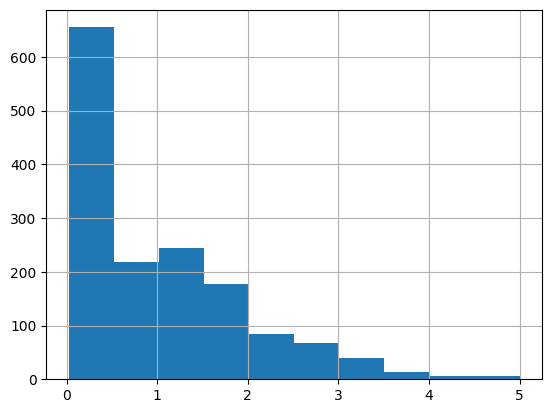

In [67]:
all_annotations_pd["VocalizationDuration"].hist()

In [68]:
all_annotations_pd.to_csv(output_clean_annotations, index=False)

In [69]:
path = f"{extracted_calls_path}/Ascending_moan"
len(list_files(path, ".wav"))

192

# Extract noise segments from raw audio files

In [87]:
if not os.path.exists(noise_path):
    os.makedirs(noise_path)

In [95]:
noise_annotations = []
for audio_file_name in audio_filenames:
    x, sr = torchaudio.load(f"{audio_path}/{audio_file_name}")
    
    print(f"Processing noise segments for {audio_file_name}")
    annotation_file_name = audio_file_name.replace(".flac", ".Table.1.selections.txt")
    df = pd.read_csv(f"{annotations_path}/{annotation_file_name}", sep="\t")
    
    # Collect noise segments
    noise_count = 0
    audio_duration = x.shape[1] / sr
    vocalization_intervals = [(row["Begin Time (s)"], row["End Time (s)"]) for _, row in df.iterrows()]
    
    attempts = 0
    while noise_count < 120 and attempts < 10:
        # Randomly select a start time for the noise segment
        potential_start_time = random.uniform(0, x.shape[1] / sr - fixed_duration)
        potential_end_time = potential_start_time + fixed_duration
        
        if potential_end_time > audio_duration:
            potential_end_time = audio_duration
            potential_start_time = potential_end_time - fixed_duration
        
        # Check if this noise segment is at least 5 seconds away from any vocalization
        valid = True
        for (v_start, v_end) in vocalization_intervals:
            if not (potential_end_time <= v_start - 5 or potential_start_time >= v_end + 5):
                valid = False
                break
        
        if valid:
            # Convert time to segment index
            start_segment = int(potential_start_time * sr)
            end_segment = int(potential_end_time * sr)

            # Ensure the segment is exactly 5 seconds long
            noise_segment = x[:, start_segment:end_segment]
            
            afn = audio_file_name.replace(".flac", "")
            if afn[-1:] == "_":
                afn = afn[:-1]
            
            noise_fn = f"{afn}_noise_{noise_count + 1}.wav"
            output_path = f"{noise_path}/{noise_fn}"
            
            torchaudio.save(output_path, noise_segment, sr)

            # Record the noise annotation with the required columns
            noise_annotations.append({
                "Filename": noise_fn,
                "SoundType": "noise"
            })

            noise_count += 1
        else:
            attempts += 1

Processing noise segments for 211026-133018-OS-humpback-47min-clip.flac
Processing noise segments for OS_10_03_2021_19_34_00_.flac
Processing noise segments for OS_10_28_2021_18_54_00_.flac
Processing noise segments for OS_10_28_2021_1900_HB.flac
Processing noise segments for OS_10_28_2021_19_24_00_.flac
Processing noise segments for OS_10_28_2021_19_55_00_.flac
Processing noise segments for OS_10_28_2021_20_25_00_HB.flac


In [96]:
noise_annotations_pd = pd.DataFrame(noise_annotations)
noise_annotations_pd.head()

,Filename,SoundType
0,211026-133018-OS-humpback-47min-clip_noise_1.wav,noise
1,211026-133018-OS-humpback-47min-clip_noise_2.wav,noise
2,211026-133018-OS-humpback-47min-clip_noise_3.wav,noise
3,211026-133018-OS-humpback-47min-clip_noise_4.wav,noise
4,211026-133018-OS-humpback-47min-clip_noise_5.wav,noise


In [98]:
noise_annotations_pd.to_csv(f"{noise_path}/metadata.csv", index=False)

In [99]:
path = f"{noise_path}/211026-133018-OS-humpback-47min-clip_noise_1.wav"
waveform, sr = torchaudio.load(path)
Audio(waveform.numpy(), rate=sr)

# Upload vocalization files into HuggingFace

In [ ]:
!mkdir huggingface
!mkdir huggingface/data

In [102]:
!cp -r data/preprocessed/* huggingface/data/

In [103]:
!mv huggingface/data/annotations_clean.csv huggingface/

In [104]:
!touch huggingface/README.md

In [72]:
data_dir="huggingface"

df = pd.read_csv(f"{data_dir}/annotations_clean.csv")

df.to_json(f"{data_dir}/metadata.jsonl", orient="records", lines=True)

In [73]:
!rm -rf huggingface/annotations_clean.csv

In [74]:
def load_audio_dataset(data_dir):
    # Define the data loading logic
    dataset = load_dataset("json", data_files=f"{data_dir}/metadata.jsonl")
    
    # Add the audio file paths to the dataset
    def add_audio_path(sample):
        sample["Audio"] = f'{data_dir}/data/{sample["CallType"]}/{sample["Filename"]}'
        return sample

    dataset = dataset.map(add_audio_path)

    # Specify the format for the audio feature
    dataset = dataset.cast_column("Audio", Audio(sampling_rate=44_100))

    #dataset["train"] = dataset["train"].remove_columns("Filename")

    return dataset

dataset = load_audio_dataset(data_dir)
print(dataset)

Generating train split: 1514 examples [00:00, 157823.25 examples/s]
Map: 100%|██████████| 1514/1514 [00:00<00:00, 8567.33 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Selection', 'BeginTime', 'EndTime', 'LowFreq', 'HighFreq', 'CallType', 'Filename', 'VocalizationDuration', 'Audio'],
        num_rows: 1514
    })
})


In [75]:
dataset.push_to_hub("Liana/humpbacks-orcasound-em-hW-data", token=<TOKEN>)

Map: 100%|██████████| 253/253 [00:25<00:00, 10.02 examples/s]

Map: 100%|██████████| 253/253 [00:24<00:00, 10.16 examples/s]

Map: 100%|██████████| 252/252 [00:25<00:00,  9.94 examples/s]

Map: 100%|██████████| 252/252 [00:22<00:00, 11.02 examples/s]

Map: 100%|██████████| 252/252 [00:26<00:00,  9.68 examples/s]

Map: 100%|██████████| 252/252 [00:29<00:00,  8.65 examples/s]

Uploading the dataset shards: 100%|██████████| 6/6 [03:36<00:00, 36.13s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Liana/humpbacks-orcasound-em-hW-data/commit/1ab142755dd43890b1da687a299ff6cf4acd9aa7', commit_message='Upload dataset', commit_description='', oid='1ab142755dd43890b1da687a299ff6cf4acd9aa7', pr_url=None, pr_revision=None, pr_num=None)

# Upload noise recordings into HuggingFace

In [76]:
!mkdir huggingface-noise
!mkdir huggingface-noise/data

In [77]:
!cp -r data/noise/* huggingface-noise/data/

In [78]:
!mv huggingface-noise/data/metadata.csv huggingface-noise/

In [79]:
!touch huggingface-noise/README.md

In [80]:
data_dir="huggingface-noise"

df = pd.read_csv(f"{data_dir}/metadata.csv")

df.to_json(f"{data_dir}/metadata.jsonl", orient="records", lines=True)

In [81]:
!rm -rf huggingface-noise/metadata.csv

In [82]:
def load_audio_dataset(data_dir):
    # Define the data loading logic
    dataset = load_dataset("json", data_files=f"{data_dir}/metadata.jsonl")
    
    # Add the audio file paths to the dataset
    def add_audio_path(sample):
        sample["Audio"] = f'{data_dir}/data/{sample["Filename"]}'
        return sample

    dataset = dataset.map(add_audio_path)

    # Specify the format for the audio feature
    dataset = dataset.cast_column("Audio", Audio(sampling_rate=44_100))

    #dataset["train"] = dataset["train"].remove_columns("Filename")

    return dataset

dataset = load_audio_dataset(data_dir)
print(dataset)

Generating train split: 160 examples [00:00, 46629.28 examples/s]
Map: 100%|██████████| 160/160 [00:00<00:00, 10428.73 examples/s]

DatasetDict({
    train: Dataset({
        features: ['Filename', 'SoundType', 'Audio'],
        num_rows: 160
    })
})


In [83]:
dataset.push_to_hub("Liana/humpbacks-orcasound-em-hW-data-noise", token=<TOKEN>)

Map: 100%|██████████| 160/160 [00:14<00:00, 11.37 examples/s]

Uploading the dataset shards: 100%|██████████| 1/1 [00:24<00:00, 24.48s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Liana/humpbacks-orcasound-em-hW-data-noise/commit/fe04dacd3652da4891aee045a4115b24eb13a04c', commit_message='Upload dataset', commit_description='', oid='fe04dacd3652da4891aee045a4115b24eb13a04c', pr_url=None, pr_revision=None, pr_num=None)

# Upload vocalization files into Azure Blob storage

To upload audio files into Azure Blob Storage, create a file local.env with the following two lines: 

- AZURE_BLOB_CONNECTION_STRING = "to be copied from Azure portal"
- AZURE_BLOB_CONTAINER_NAME = "existing container in Blob storage where files should be uploaded, e.g. azureml"

In [105]:
# load environment variables from local.env file
load_dotenv(dotenv_path="local.env")

connection_string = os.getenv("AZURE_BLOB_CONNECTION_STRING")
container_name = os.getenv("AZURE_BLOB_CONTAINER_NAME") # Name of container where files should be uploaded

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
blob_container_client = blob_service_client.get_container_client(container_name)

local_source_files_folder = data_download_folder

for root, dirs, files in os.walk(local_source_files_folder):
    for file in files:
        file_path = os.path.join(root, file)
        blob_name = os.path.relpath(file_path, local_source_files_folder).replace("\\", "/")
        blob_client = blob_container_client.get_blob_client(blob_name)
        
        with open(file_path, "rb") as data:
            blob_client.upload_blob(data)